In [60]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import wrds
#db.create_pgpass_file()


In [61]:
df=pd.read_csv('data.csv',sep=';')
df['date'] = pd.to_datetime(df['date'])
df.head()

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e
0,10028,1992-06-30,-0.206897,5632.0,-1.43750,8096.000,NaN,0.002928,-0.019258,1,-0.209825,-0.022186
1,10028,1992-05-29,-0.205479,5548.0,-1.81250,10055.750,8096.000,0.003030,0.006407,1,-0.208509,0.003377
2,10028,1992-04-30,-0.170455,5548.0,-2.28125,12656.375,10055.750,0.002920,0.013414,1,-0.173375,0.010494
3,10028,1992-03-31,0.419355,5548.0,2.75000,15257.000,12656.375,0.003343,-0.023699,1,0.416012,-0.027042
4,10028,1998-05-29,0.047619,4151.0,2.75000,11415.250,15257.000,0.003806,-0.025746,1,0.043813,-0.029552


# **Part 3: Betting Against Beta**

## Estimating rolling betas

In [62]:
#Copying df3frame for safe measure
df3=df.copy()


In [63]:
#Drop NaNs
df3=df3.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

#Remove scarce df3 
df3['N'] = df3.groupby(['permno'])['date'].transform('count')
df3 = df3[df3['N']>60].copy()

#Estimate Rolling Betas
cov_nm = df3.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(60, min_periods=36).cov()
#beta_n = (cov_nm.iloc[1::2,1].droplevel(2)/cov_nm.iloc[0::2,1].droplevel(2))
beta_n = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})

#reconstruct df
beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)
df3 = pd.merge(df3, beta_n, on=['date','permno'], how='left')

#Winsorsize
df3['beta'] = df3['beta'].clip(df3['beta'].quantile(0.05),df3['beta'].quantile(0.95))

#Show first 5 rows
df3.head()

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,N,beta
0,10028,1992-05-29,-0.205479,5548.0,-1.81250,10055.750,8096.000,0.003030,0.006407,1,-0.208509,0.003377,274,NaN
1,10028,1992-04-30,-0.170455,5548.0,-2.28125,12656.375,10055.750,0.002920,0.013414,1,-0.173375,0.010494,274,NaN
2,10028,1992-03-31,0.419355,5548.0,2.75000,15257.000,12656.375,0.003343,-0.023699,1,0.416012,-0.027042,274,NaN
3,10028,1998-05-29,0.047619,4151.0,2.75000,11415.250,15257.000,0.003806,-0.025746,1,0.043813,-0.029552,274,NaN
4,10028,1998-04-30,0.050000,4151.0,2.62500,10896.375,11415.250,0.003940,0.010924,1,0.046060,0.006984,274,NaN


## PF Decile

In [64]:
#Generate Quantiles
df3=df3.dropna(subset=['beta']).copy()
df3['beta_q']=df3.groupby('date')['beta'].transform(lambda x :  pd.qcut(x, 10,labels=False, duplicates='drop'))

#Equal-Weighted pfs
ret_ew = df3.groupby(['date','beta_q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('beta_q')['Rn'].mean()*12
ew_ret_std = ret_ew.groupby('beta_q')['Rn'].std()*(np.sqrt(12))
ew_rf_mean=df3.groupby('beta_q')['rf'].mean()*12
ew_sr=(ew_ret_mean-ew_rf_mean)/(ew_ret_std)



# Value-weighed pfs
df3['vw_Q']=df3['mcap']/(df3.groupby(['date','beta_q'])['mcap'].transform('sum'))
df3['ret_vw'] = df3['vw_Q']*df3['Rn']
ret_vw = df3.groupby(['date','beta_q'])['ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('beta_q')['ret_vw'].mean()*12
vw_ret_std = ret_vw.groupby('beta_q')['ret_vw'].std()*(np.sqrt(12))
vw_rf_mean=df3.groupby('beta_q')['rf'].mean()*12
vw_sr=(vw_ret_mean-vw_rf_mean)/(vw_ret_std)

In [65]:
#Constuct dataframes for efficient plotting 
deciles=['Q'+ str(x) for x in np.arange(1,11)]
means=np.concatenate((vw_ret_mean.values,ew_ret_mean.values))
means_df=pd.DataFrame(zip(means,['VW']*len(vw_ret_mean.values)+['EW']*len(ew_ret_mean.values),deciles+deciles),columns=['values','type','quantile'])
stds=np.concatenate((vw_ret_std.values,ew_ret_std.values))
stds_df=pd.DataFrame(zip(stds,['VW']*len(vw_ret_mean.values)+['EW']*len(ew_ret_mean.values),deciles+deciles),columns=['values','type','quantile'])
srs=np.concatenate((vw_sr.values,ew_sr.values))
srs_df=pd.DataFrame(zip(srs,['VW']*len(vw_sr.values)+['EW']*len(ew_sr.values),deciles+deciles),columns=['values','type','quantile'])

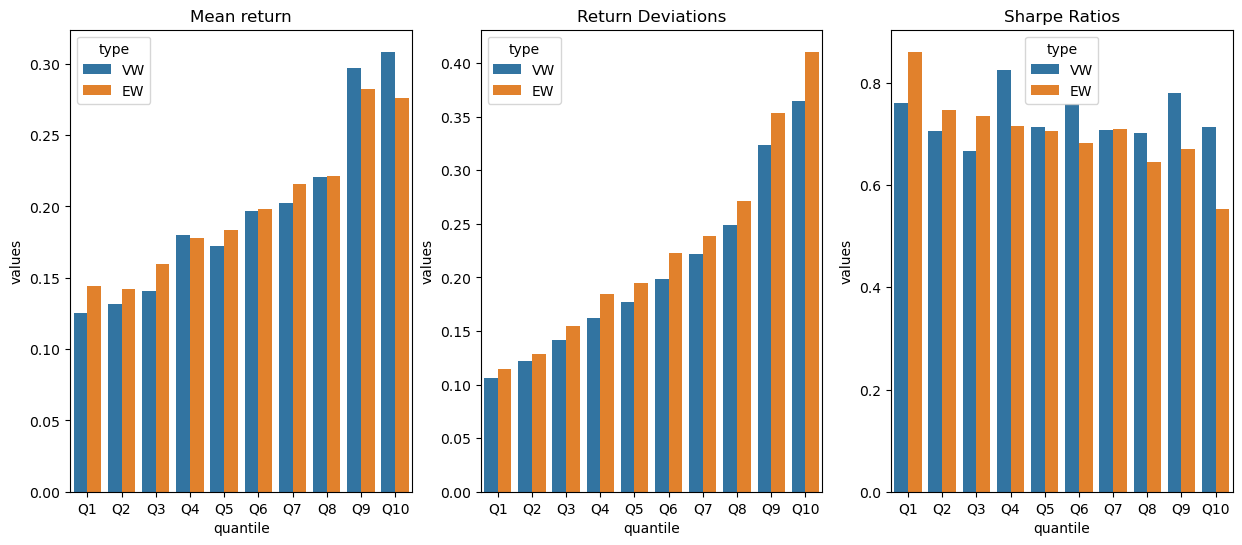

In [66]:
import seaborn as sns
# 5. Plot Means Histogram
fig, axs= plt.subplots(1,3,figsize=(15,6))
sns.barplot(means_df,x='quantile',y='values',hue='type',ax=axs[0])
sns.barplot(stds_df,x='quantile',y='values',hue='type',ax=axs[1])
sns.barplot(srs_df,x='quantile',y='values',hue='type',ax=axs[2])

axs[0].set_title('Mean return')
axs[1].set_title('Return Deviations')
axs[2].set_title('Sharpe Ratios')
plt.show()


## BAB PF Construction

In [67]:
# Weights
df3['z'] = df3.groupby('date')['beta'].transform(lambda x: x.rank())
df3['z_'] = df3['z']-df3.groupby('date')['z'].transform('mean')
df3['k'] = np.abs(df3['z_'])
df3['k'] = 2/df3.groupby('date')['k'].transform('sum')
df3['w_H'] = df3['k'] * df3['z_'] * (df3['z_']>0) 
df3['w_L'] = -df3['k'] * df3['z_'] * (df3['z_']<0)

# Weighted returns and beta
df3['beta_H'] = df3['w_H'] * df3['beta']
df3['beta_L'] = df3['w_L'] * df3['beta']
df3['R_H'] = df3['w_H'] * df3['Rn']
df3['R_L'] = df3['w_L'] * df3['Rn']
df3['R_H_e'] = df3['w_H'] * df3['Rn_e']
df3['R_L_e'] = df3['w_L'] * df3['Rn_e']
BAB = df3.groupby('date')[['R_H','R_L','R_H_e','R_L_e','beta_H','beta_L']].sum().reset_index()
BAB['BAB2'] = BAB['R_L_e']/BAB['beta_L'] - BAB['R_H_e']/BAB['beta_H']


In [68]:
# Merge Market and Risk free Rate
tmp = pd.merge(BAB,df3[['date','Rm_e']].drop_duplicates(), on=['date'], how='left')
tmp['const'] = 1

# Alpha and Beta
import statsmodels.api as sm
tmp = tmp.dropna()
OLS_Reg = sm.OLS(tmp['BAB2'], tmp[['const','Rm_e']]).fit()

Alpha_bab = OLS_Reg.params[0]*12
idio_vol = (tmp['BAB2']-OLS_Reg.predict()).std()*np.sqrt(12)
market_rp = tmp['Rm_e'].mean()*12
market_vol = tmp['Rm_e'].std()*np.sqrt(12)
beta_bab = OLS_Reg.params[1]

print('Annualized Alpha of BAB factor: ', Alpha_bab, OLS_Reg.tvalues[0])
print('Sharpe Ratio of BAB factor: ',tmp['BAB2'].mean()/tmp['BAB2'].std()*np.sqrt(12))
print('Idiosyncatic volatility: ',idio_vol)
print('Beta BAB: ',beta_bab)
print('Market Risk Premium: ',market_rp)
print('Market Volatility: ',market_vol)

Annualized Alpha of BAB factor:  0.07731393113903845 2.648617234533433
Sharpe Ratio of BAB factor:  0.5749251659873538
Idiosyncatic volatility:  0.13434084969178267
Beta BAB:  -0.00099618561241141
Market Risk Premium:  0.0782370197635887
Market Volatility:  0.1641776899936966


C:\Users\Kamal\AppData\Local\Temp\ipykernel_70208\3891231813.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Alpha_bab = OLS_Reg.params[0]*12
C:\Users\Kamal\AppData\Local\Temp\ipykernel_70208\3891231813.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_bab = OLS_Reg.params[1]
C:\Users\Kamal\AppData\Local\Temp\ipykernel_70208\3891231813.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Annualized Alpha of BAB f

# **Part 5: Idiosyncratic Volatility**


In [69]:
df5=df.copy()
df5.dropna(subset=['Rn_e','Rm_e'],inplace=True)


In [70]:
df_indexed = df5.set_index('date')

# Step 2: Group by 'permno'
grouped = df_indexed.groupby('permno')

# Step 3: Define a function to compute idiosyncratic volatility
def compute_idiosyncratic_volatility(group):
    # Check if there are at least 36 months of observations
    if len(group) < 36:
        return pd.Series(np.nan, index=group.index)
    
    # Perform rolling 5-year regression of Rn_e on Rm_e
    rolling_window = 60  # 12 months per year * 5 years
    min_periods = 36
    residuals = group['Rn_e'] - group['Rm_e'].rolling(window=rolling_window, min_periods=min_periods).mean()
    
    # Compute rolling standard deviation of residuals
    volatilities = residuals.rolling(window=rolling_window, min_periods=min_periods).std()
    
    # Winsorize at 5th and 95th percentiles
    volatilities = volatilities.clip(lower=volatilities.quantile(0.05), upper=volatilities.quantile(0.95))
    
    return volatilities

# Step 4: Apply the function to each group
idiosyncratic_volatility = grouped.apply(compute_idiosyncratic_volatility)

C:\Users\Kamal\AppData\Local\Temp\ipykernel_70208\3394252169.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  idiosyncratic_volatility = grouped.apply(compute_idiosyncratic_volatility)


In [71]:
df_idio=idiosyncratic_volatility.reset_index()
df5=df5.merge(df_idio,on=['date','permno'])
df5.rename(columns={0:'idio_vol'},inplace=True)
df5.head()

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,idio_vol
0,10028,1992-06-30,-0.206897,5632.0,-1.43750,8096.000,NaN,0.002928,-0.019258,1,-0.209825,-0.022186,NaN
1,10028,1992-05-29,-0.205479,5548.0,-1.81250,10055.750,8096.000,0.003030,0.006407,1,-0.208509,0.003377,NaN
2,10028,1992-04-30,-0.170455,5548.0,-2.28125,12656.375,10055.750,0.002920,0.013414,1,-0.173375,0.010494,NaN
3,10028,1992-03-31,0.419355,5548.0,2.75000,15257.000,12656.375,0.003343,-0.023699,1,0.416012,-0.027042,NaN
4,10028,1998-05-29,0.047619,4151.0,2.75000,11415.250,15257.000,0.003806,-0.025746,1,0.043813,-0.029552,NaN


## Decile soting

In [72]:
#Generate Quantiles
df5=df5.dropna(subset=['idio_vol']).copy()
df5['idio_q']=df5.groupby('date')['idio_vol'].transform(lambda x :  pd.qcut(x, 10,labels=False, duplicates='drop'))

#Equal-Weighted pfs
ret_ew = df5.groupby(['date','idio_q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('idio_q')['Rn'].mean()*12
ew_rf_mean=df5.groupby('idio_q')['rf'].mean()*12
ew_ret_std = ret_ew.groupby('idio_q')['Rn'].std()*(np.sqrt(12))
ew_sr=(ew_ret_mean-ew_rf_mean)/(ew_ret_std)


# Value-weighed pfs
df5['vw_Q']=df5['mcap']/(df5.groupby(['date','idio_q'])['mcap'].transform('sum'))
df5['ret_vw'] = df5['vw_Q']*df5['Rn']

ret_vw = df5.groupby(['date','idio_q'])['ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('idio_q')['ret_vw'].mean()*12
vw_rf_mean = df5.groupby('idio_q')['rf'].mean()*12
vw_ret_std = ret_vw.groupby('idio_q')['ret_vw'].std()*(np.sqrt(12))
vw_sr=(vw_ret_mean-vw_rf_mean)/(vw_ret_std)

df5.head()

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,idio_vol,idio_q,vw_Q,ret_vw
70,10028,1992-11-30,-0.185185,5626.0,-1.37500,7735.750,7735.750,0.002225,0.040181,1,-0.187410,0.037956,0.167869,9,0.000619,-0.000115
71,10028,1992-10-30,-0.035714,5626.0,-1.68750,9493.875,7735.750,0.002310,0.010983,1,-0.038024,0.008673,0.167869,9,0.000813,-0.000029
72,10028,1992-09-30,0.076923,5626.0,-1.75000,9845.500,9493.875,0.002242,0.012461,1,0.074681,0.010219,0.167869,9,0.000826,0.000064
73,10028,1992-08-31,0.019608,5632.0,-1.62500,9152.000,9845.500,0.002521,-0.020819,1,0.017087,-0.023340,0.167869,9,0.000765,0.000015
74,10028,1992-07-31,0.108696,5632.0,-1.59375,8976.000,9152.000,0.002564,0.039900,1,0.106132,0.037336,0.167869,9,0.000696,0.000076


In [73]:
#Constuct dataframes for efficient plotting 
deciles=['Q'+ str(x) for x in np.arange(1,11)]
means=np.concatenate((vw_ret_mean.values,ew_ret_mean.values))
means_df=pd.DataFrame(zip(means,['VW']*len(vw_ret_mean.values)+['EW']*len(ew_ret_mean.values),deciles+deciles),columns=['values','type','quantile'])
stds=np.concatenate((vw_ret_std.values,ew_ret_std.values))
stds_df=pd.DataFrame(zip(stds,['VW']*len(vw_ret_mean.values)+['EW']*len(ew_ret_mean.values),deciles+deciles),columns=['values','type','quantile'])
srs=np.concatenate((vw_sr.values,ew_sr.values))
srs_df=pd.DataFrame(zip(srs,['VW']*len(vw_sr.values)+['EW']*len(ew_sr.values),deciles+deciles),columns=['values','type','quantile'])


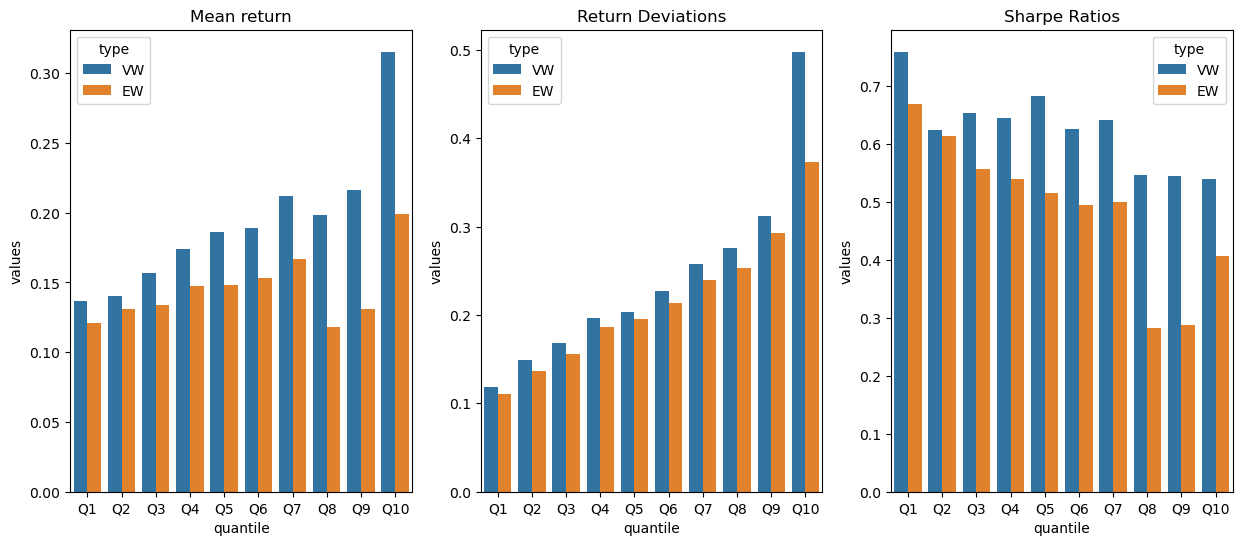

In [74]:
import seaborn as sns
# 5. Plot Means Histogram
fig, axs= plt.subplots(1,3,figsize=(15,6))
sns.barplot(means_df,x='quantile',y='values',hue='type',ax=axs[0])
sns.barplot(stds_df,x='quantile',y='values',hue='type',ax=axs[1])
sns.barplot(srs_df,x='quantile',y='values',hue='type',ax=axs[2])

axs[0].set_title('Mean return')
axs[1].set_title('Return Deviations')
axs[2].set_title('Sharpe Ratios')
plt.show()



## Constructing Volatility portfolio

In [75]:
##Construct three dataframes, one for the strategy and one for the higher deciels and lower decile portfolios
df_deciles=df5[df5['idio_q'].isin([0,1,2,7,8,9])].copy()
df_h=df_deciles[df_deciles['idio_q'].isin([7,8,9])]
df_l=df_deciles[df_deciles['idio_q'].isin([0,1,2])]

Equal weighted strategy

In [76]:
## Short the 3 lowest decile returns to apply the strategy
df_deciles['Rn']=df_deciles.apply(lambda row: (-1)*row['Rn'] if row['idio_q'] in [0,1, 2] else row['Rn'], axis=1)

In [77]:
## PRINTING THE PROPERTIES OF THE DIFFERENT STRATEGIES
mean_h=df_h['Rn'].mean()*12
mean_l=df_l['Rn'].mean()*12
mean_strat=df_deciles['Rn'].mean()*12

std_h=df_h['Rn'].std()*(np.sqrt(12))
std_l=df_l['Rn'].std()*(np.sqrt(12))
std_strat=df_deciles['Rn'].std()*(np.sqrt(12))

sr_h=(mean_h-df_h['rf'].mean())/(std_h)
sr_l=(mean_l-df_l['rf'].mean())/(std_l)
sr_strat=(mean_strat-df_deciles['rf'].mean())/(std_strat)


print('-----Annual Return Means-----')
print(f'High Deciles: {mean_h}, Low Deciles: {mean_l}, Strategy: {mean_strat}')
print('-----Annual Return Deviations-----')
print(f'High Deciles: {std_h}, Low Deciles: {std_l}, Strategy: {std_strat}')
print('-----Sharpe Ratios-----')
print(f'High Deciles: {sr_h}, Low Deciles: {sr_l}, Strategy: {sr_strat}')



-----Annual Return Means-----
High Deciles: 0.1387803458281105, Low Deciles: 0.13093960149794232, Strategy: 0.003901755450044137
-----Annual Return Deviations-----
High Deciles: 0.6921580297751078, Low Deciles: 0.24613673076787052, Strategy: 0.5208831365759289
-----Sharpe Ratios-----
High Deciles: 0.1948476771834002, Low Deciles: 0.5160738208743696, Strategy: -2.527338881429298e-05


In [78]:
## Statistical testing for pvalues
from scipy.stats import ttest_ind
_, pval=ttest_ind(df_deciles.groupby('date')['Rn'].mean()*12,0)
print(pval)

0.9780136399007177


The test's p-value is above 5%, we can conclude that the returns or our long short strategy are statistically different that 0.

In [79]:

df_deciles['ret_vw']=df_deciles.apply(lambda row: (-1)*row['ret_vw'] if row['idio_q'] in [0,1, 2] else row['ret_vw'], axis=1)
df_deciles['is_long']=df_deciles.apply(lambda row:  0 if row['idio_q'] in [0,1, 2] else 1, axis=1)
df_deciles.head()

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,idio_vol,idio_q,vw_Q,ret_vw,is_long
70,10028,1992-11-30,-0.185185,5626.0,-1.37500,7735.750,7735.750,0.002225,0.040181,1,-0.187410,0.037956,0.167869,9,0.000619,-0.000115,1
71,10028,1992-10-30,-0.035714,5626.0,-1.68750,9493.875,7735.750,0.002310,0.010983,1,-0.038024,0.008673,0.167869,9,0.000813,-0.000029,1
72,10028,1992-09-30,0.076923,5626.0,-1.75000,9845.500,9493.875,0.002242,0.012461,1,0.074681,0.010219,0.167869,9,0.000826,0.000064,1
73,10028,1992-08-31,0.019608,5632.0,-1.62500,9152.000,9845.500,0.002521,-0.020819,1,0.017087,-0.023340,0.167869,9,0.000765,0.000015,1
74,10028,1992-07-31,0.108696,5632.0,-1.59375,8976.000,9152.000,0.002564,0.039900,1,0.106132,0.037336,0.167869,9,0.000696,0.000076,1


In [80]:
df_deciles['vw_Q2']=df_deciles['mcap']/(df_deciles.groupby(['date','is_long'])['mcap'].transform('sum'))
df_deciles['ret_vw2'] = df_deciles['vw_Q2']*df_deciles['Rn']

In [81]:
## PRINTING THE PROPERTIES OF THE DIFFERENT STRATEGIES
mean_h=df_deciles[df_deciles['idio_q'].isin([7,8,9])]['ret_vw2'].mean()*12
mean_l=df_deciles[df_deciles['idio_q'].isin([0,1,2])]['ret_vw2'].mean()*12
mean_strat=df_deciles['ret_vw'].mean()*12

std_h=df_deciles[df_deciles['idio_q'].isin([7,8,9])]['ret_vw2'].std()*(np.sqrt(12))
std_l==df_deciles[df_deciles['idio_q'].isin([0,1,2])]['ret_vw2'].std()*(np.sqrt(12))
std_strat=df_deciles['ret_vw2'].std()*(np.sqrt(12))

sr_h=(mean_h-df_h['rf'].mean())/(std_h)
sr_l=(mean_l-df_l['rf'].mean())/(std_l)
sr_strat=(mean_strat-df_deciles['rf'].mean())/(std_strat)


print('-----Annual Return Means-----')
print(f'High Deciles: {mean_h}, Low Deciles: {mean_l}, Strategy: {mean_strat}')
print('-----Annual Return Deviations-----')
print(f'High Deciles: {std_h}, Low Deciles: {std_l}, Strategy: {std_strat}')
print('-----Sharpe Ratios-----')
print(f'High Deciles: {sr_h}, Low Deciles: {sr_l}, Strategy: {sr_strat}')



-----Annual Return Means-----
High Deciles: 0.0006113360584576387, Low Deciles: -0.0003756144300766253, Strategy: 0.0003868224422414266
-----Annual Return Deviations-----
High Deciles: 0.006540538516105042, Low Deciles: 0.24613673076787052, Strategy: 0.004895875423331733
-----Sharpe Ratios-----
High Deciles: -0.5050999112687261, Low Deciles: -0.017431339116811086, Strategy: -0.720626483473566


In [82]:
## Statistical testing for pvalues
_, pval=ttest_ind(df_deciles.groupby('date')['ret_vw2'].mean()*12,0)
print(pval)

0.9508125904468794


The test's p-value is above 5%, we can conclude that the returns or our long short strategy are statistically different that 0.